In [6]:
!pip install neurokit2
!pip install py-ecg-detectors
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
from ecgdetectors import Detectors


  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=fe9ac4eed27a69d526bf5a10457321cac6cb34901db2a55c149471100f9bea84
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\bb\49\5c\82f92e0ba9a437102b891c68367490fe9fca79df9075059e4e
Successfully built gatspy


Se carga el archivo y se conoce la estructura de los datos tanto filas como columnas

In [7]:
file_path = 'Diagnostics.xlsx'
df = pd.read_excel(file_path)

print("Columnas del DataFrame:")
print(df.columns.tolist())

print("Primeras filas del DataFrame:")
print(df.head())

print("\nColumnas del archivo:")
print(df.columns)

Columnas del DataFrame:
['FileName', 'Rhythm', 'Beat', 'PatientAge', 'Gender', 'VentricularRate', 'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'TOffset']
Primeras filas del DataFrame:
                     FileName Rhythm       Beat  PatientAge  Gender  \
0  MUSE_20180113_171327_27000   AFIB   RBBB TWC          85    MALE   
1  MUSE_20180112_073319_29000     SB        TWC          59  FEMALE   
2  MUSE_20180111_165520_97000     SA       NONE          20  FEMALE   
3  MUSE_20180113_121940_44000     SB       NONE          66    MALE   
4  MUSE_20180112_122850_57000     AF  STDD STTC          73  FEMALE   

   VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  RAxis  \
0              117         234          114         356          496     81   
1               52          52           92         432          401     76   
2               67          67           82         382          403     88   
3        

Conocer la cantidad de datos de nuestra base

In [8]:
#Estadisticas generales
print("\nResumen estadístico:")
print(df.describe(include='all'))
# Renombrar columnas si es necesario (ejemplo estándar)
# df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


Resumen estadístico:
                          FileName Rhythm   Beat    PatientAge Gender  \
count                        10646  10646  10646  10646.000000  10646   
unique                       10646     11    742           NaN      2   
top     MUSE_20180113_171327_27000     SB   NONE           NaN   MALE   
freq                             1   3889   5419           NaN   5956   
mean                           NaN    NaN    NaN     59.186831    NaN   
std                            NaN    NaN    NaN     18.030019    NaN   
min                            NaN    NaN    NaN      4.000000    NaN   
25%                            NaN    NaN    NaN     49.000000    NaN   
50%                            NaN    NaN    NaN     62.000000    NaN   
75%                            NaN    NaN    NaN     72.000000    NaN   
max                            NaN    NaN    NaN     98.000000    NaN   

        VentricularRate   AtrialRate   QRSDuration    QTInterval  \
count      10646.000000  10646.00

Arritmia mas prevalente


✅ Arritmias más prevalentes:
SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Rhythm, dtype: int64


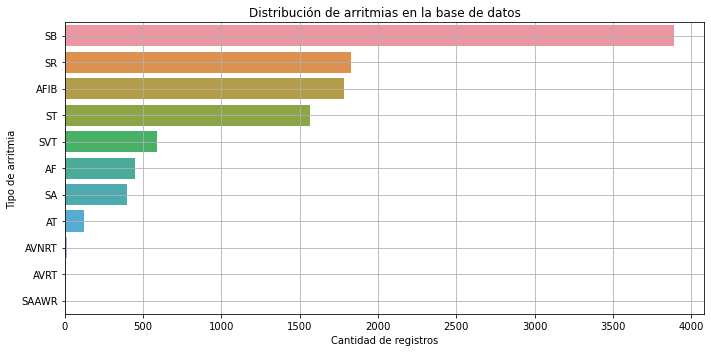

In [9]:
arritmia_col = 'Rhythm'  # Esta columna tiene los tipos de ritmo/arritmia
arritmias = df[arritmia_col].value_counts()

print("\n✅ Arritmias más prevalentes:")
print(arritmias)

plt.figure(figsize=(10, 5))
sns.countplot(data=df, y=arritmia_col, order=arritmias.index)
plt.title("Distribución de arritmias en la base de datos")
plt.xlabel("Cantidad de registros")
plt.ylabel("Tipo de arritmia")
plt.grid(True)
plt.tight_layout()
plt.show()

Prevalencia de genero

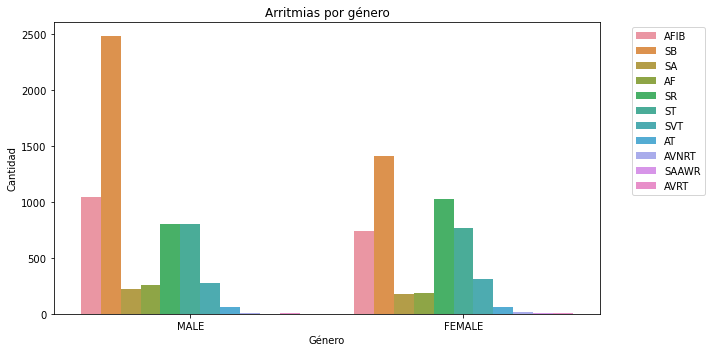

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Gender', hue=arritmia_col)
plt.title("Arritmias por género")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Prevalencia de edad

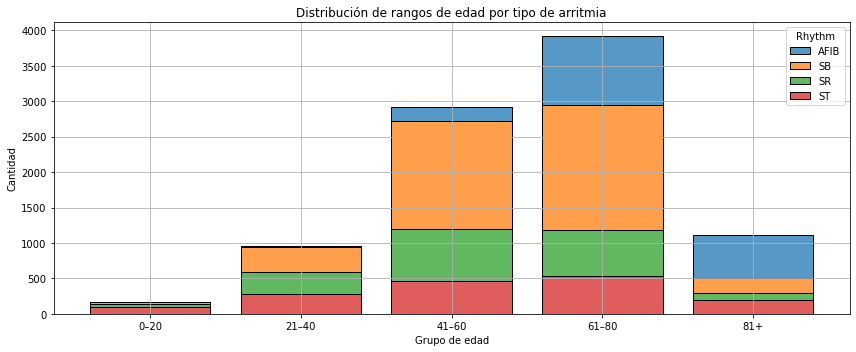

In [11]:
bins = [0, 20, 40, 60, 80, 120]
labels = ['0–20', '21–40', '41–60', '61–80', '81+']
df['AgeGroup'] = pd.cut(df['PatientAge'], bins=bins, labels=labels, right=False)

# Top 4 arritmias
arritmias = df[arritmia_col].value_counts()
top4_rhythms = arritmias.head(4).index.tolist()

# Filtrar dataframe para solo las 4 arritmias
df_top4 = df[df[arritmia_col].isin(top4_rhythms)]

# Plot usando grupos de edad
plt.figure(figsize=(12, 5))
sns.histplot(
    data=df_top4,
    x='AgeGroup',
    hue=arritmia_col,
    multiple="stack",
    shrink=0.8,
    discrete=True  # Muy importante para que trate AgeGroup como categorías, no como continuo
)
plt.title("Distribución de rangos de edad por tipo de arritmia")
plt.xlabel("Grupo de edad")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
print("\nDistribución de edades:")
print(df['PatientAge'].describe())


Distribución de edades:
count    10646.000000
mean        59.186831
std         18.030019
min          4.000000
25%         49.000000
50%         62.000000
75%         72.000000
max         98.000000
Name: PatientAge, dtype: float64


¿Qué datos se pueden usar para entrenar modelos?

In [13]:
# Calcular las 4 arritmias más frecuentes
arritmias = df['Rhythm'].value_counts()
top4_rhythms = arritmias.head(4).index.tolist()

# Definir los intervalos de edad
bins = [0, 20, 40, 60, 80, 120]
labels = ['0–20', '21–40', '41–60', '61–80', '81+']
df['AgeGroup'] = pd.cut(df['PatientAge'], bins=bins, labels=labels)

# Filtrar solo las arritmias más comunes
df_top4 = df[df['Rhythm'].isin(top4_rhythms)]

# Contar cuántos registros hay por grupo de edad y arritmia
age_rhythm_distribution = df_top4.groupby(['AgeGroup', 'Rhythm']).size().unstack(fill_value=0)

# Mostrar resultados
print("Distribución de las 4 arritmias más comunes por rango de edad:")
print(age_rhythm_distribution)

print(f"\nSe recomienda enfocarse en estos rangos de edad con más registros:")
print(df['AgeGroup'].value_counts().sort_index().to_string())

print(f"\nY en estas arritmias más comunes: {top4_rhythms}")


Distribución de las 4 arritmias más comunes por rango de edad:
Rhythm    AFIB    SB   SR   ST
AgeGroup                      
0–20         0    40   36  117
21–40       10   364  335  277
41–60      218  1639  751  474
61–80     1022  1664  613  532
81+        530   182   91  168

Se recomienda enfocarse en estos rangos de edad con más registros:
0–20      359
21–40    1231
41–60    3478
61–80    4395
81+      1183

Y en estas arritmias más comunes: ['SB', 'SR', 'AFIB', 'ST']


- Al entrenar modelos, es importante contar con una cantidad suficiente de datos por categoría para evitar sesgos.
- Los grupos de edad con más registros permiten entrenar modelos más robustos y generalizables.
- Además, según los análisis anteriores, estas arritmias aparecen como las más prevalentes tanto en general como en los distintos géneros y grupos de edad, por lo que son relevantes clínicamente.

- Aunque el género muestra ciertas diferencias en tipos de arritmia, no es tan determinante como la edad y las variables fisiológicas."
- Es más efectivo seleccionar grupos etarios bien representados y centrarse en arritmias comunes.
- Un análisis de importancia de variables puede confirmar qué atributos tienen mayor poder predictivo."
- Si en el futuro se encuentran diferencias clínicas marcadas por género, se puede entrenar un modelo separado para cada uno.


Distribución porcentual de arritmias por género:

Rhythm   AF  AFIB   AT  AVNRT  AVRT   SA  SAAWR    SB    SR    ST  SVT
Gender                                                                
FEMALE  4.0  15.8  1.2    0.3   0.1  3.8    0.1  30.0  21.8  16.4  6.6
MALE    4.3  17.5  1.1    0.1   0.1  3.7    0.0  41.7  13.5  13.4  4.7


<Figure size 720x432 with 0 Axes>

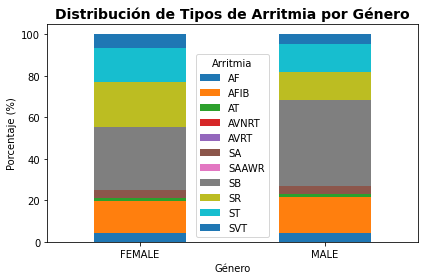


Distribución porcentual de arritmias por grupo de edad:

Rhythm     AF  AFIB   AT  AVNRT  AVRT    SA  SAAWR    SB    SR    ST  SVT
AgeGroup                                                                 
0–20      0.0   0.0  1.7    0.0   0.0  39.8    0.6  11.1  10.0  32.6  4.2
21–40     1.1   0.8  0.6    0.2   0.1   8.9    0.1  29.6  27.2  22.5  8.9
41–60     2.2   6.3  0.5    0.2   0.1   2.1    0.0  47.1  21.6  13.6  6.4
61–80     5.6  23.3  1.5    0.1   0.1   1.5    0.0  37.9  13.9  12.1  4.1
81+       9.5  44.8  1.9    0.3   0.0   0.7    0.2  15.4   7.7  14.2  5.4


<Figure size 864x504 with 0 Axes>

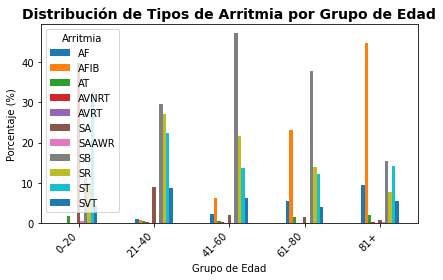

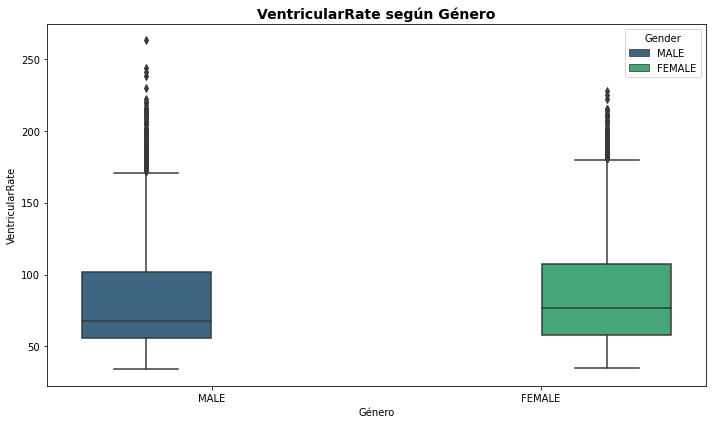

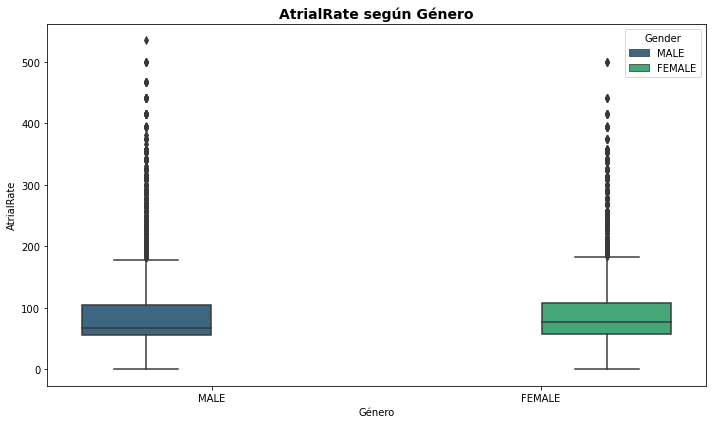

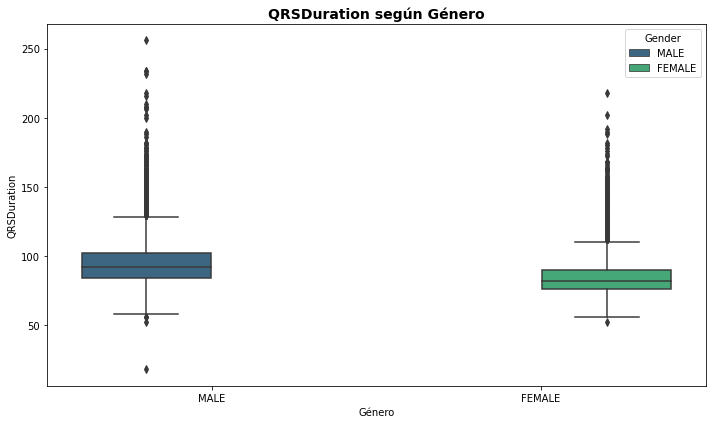

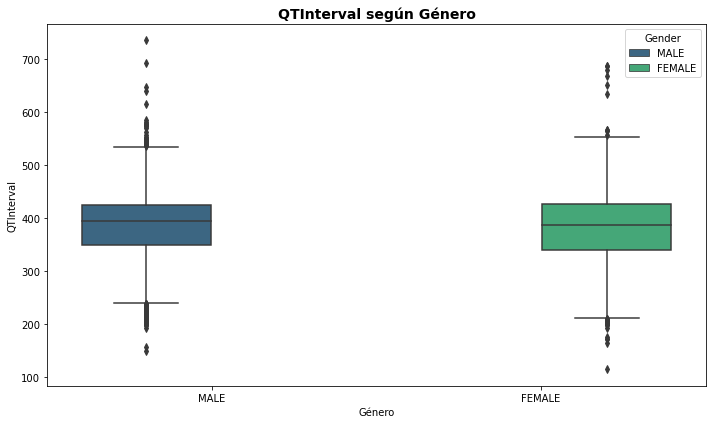

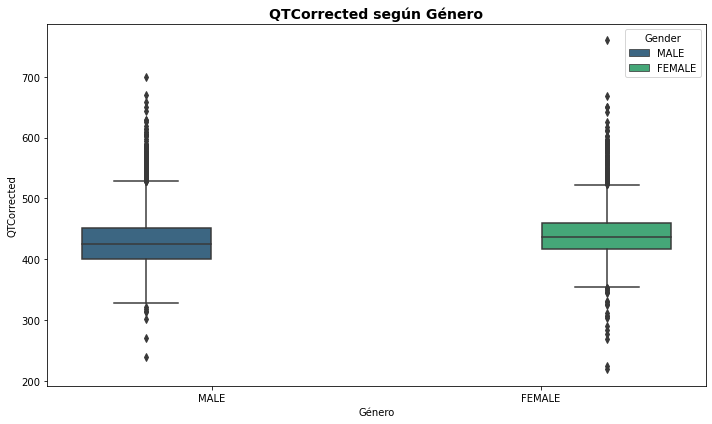

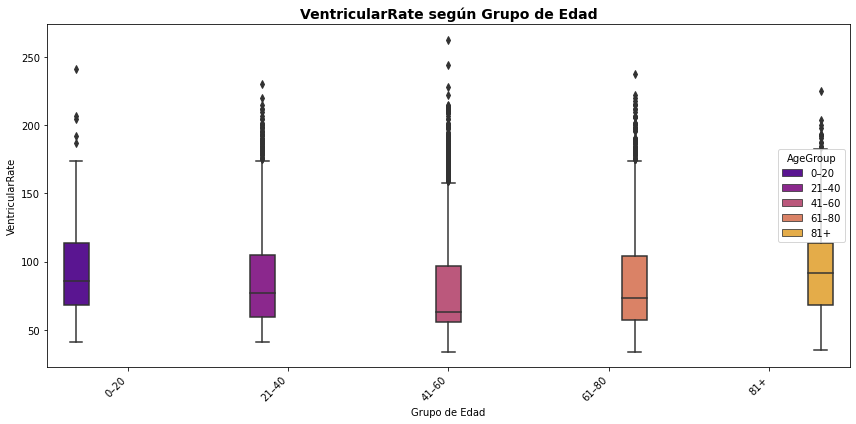

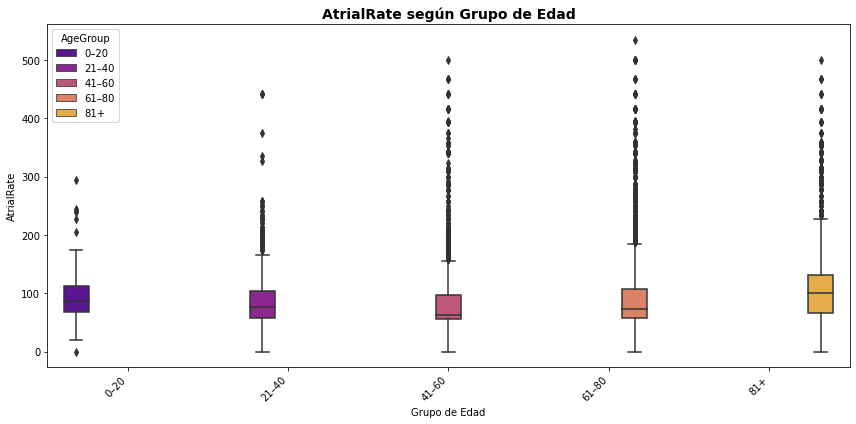

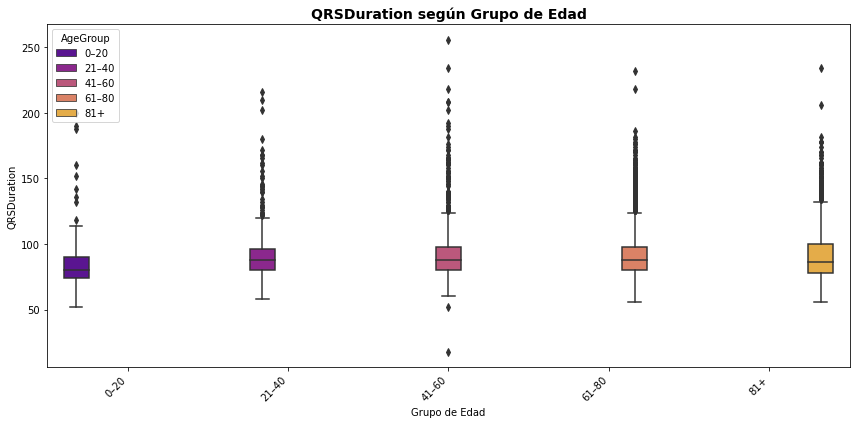

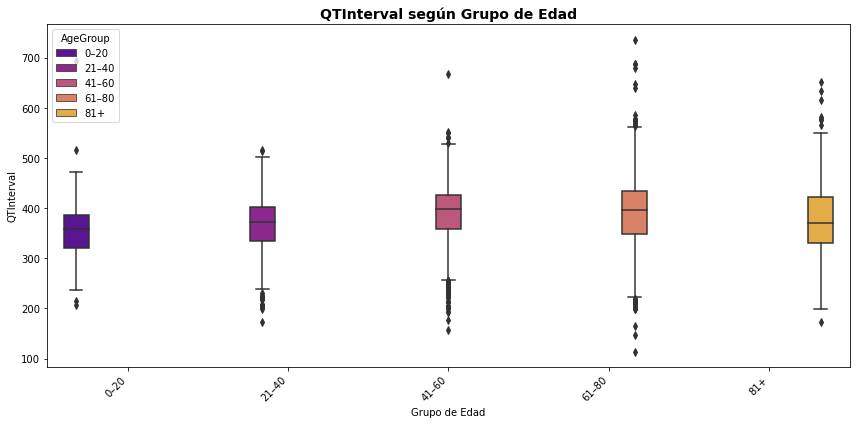

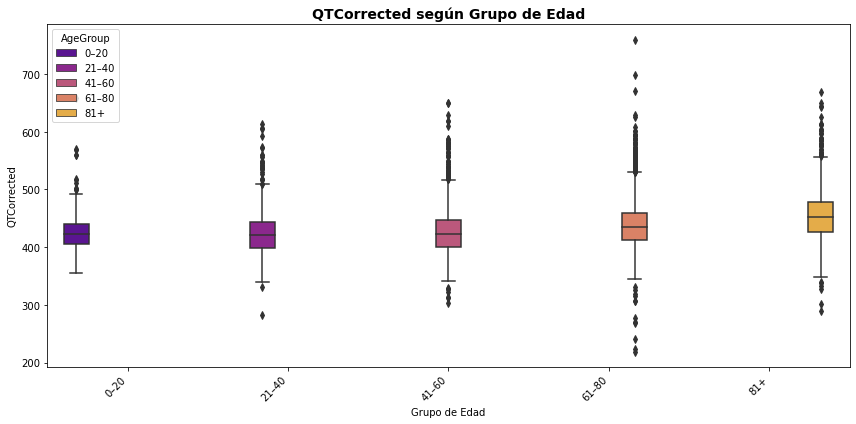


Correlación entre variables fisiológicas:


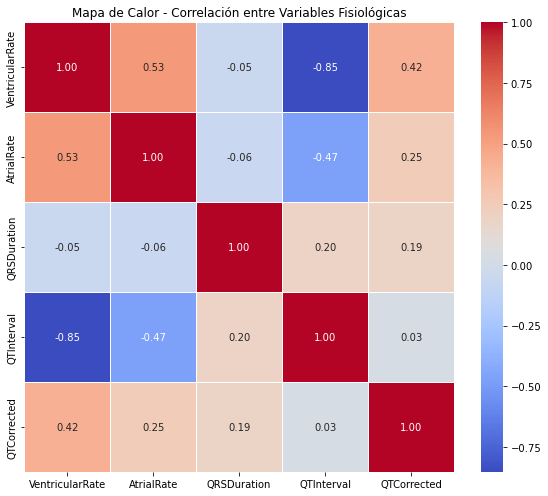

In [19]:
# Variables fisiológicas a analizar
fisiologicas = ['VentricularRate', 'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected']

# --- 1. Distribución de tipos de arritmia según el género ---
tabla_genero_arritmia = pd.crosstab(df['Gender'], df['Rhythm'])
porcentaje_genero = tabla_genero_arritmia.div(tabla_genero_arritmia.sum(axis=1), axis=0) * 100

print("\nDistribución porcentual de arritmias por género:\n")
print(porcentaje_genero.round(1).to_string())

# Visualización
plt.figure(figsize=(10, 6))
porcentaje_genero.plot(kind='bar', stacked=True)
plt.title("Distribución de Tipos de Arritmia por Género", fontsize=14, fontweight='bold')
plt.xlabel("Género")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=0)
plt.legend(title='Arritmia')
plt.tight_layout()
plt.show()

# --- 2. Distribución de tipos de arritmia según grupo etario ---
tabla_edad_arritmia = pd.crosstab(df['AgeGroup'], df['Rhythm'])
porcentaje_edad = tabla_edad_arritmia.div(tabla_edad_arritmia.sum(axis=1), axis=0) * 100

print("\nDistribución porcentual de arritmias por grupo de edad:\n")
print(porcentaje_edad.round(1).to_string())

# Visualización
plt.figure(figsize=(12, 7))
porcentaje_edad.plot(kind='bar')
plt.title("Distribución de Tipos de Arritmia por Grupo de Edad", fontsize=14, fontweight='bold')
plt.xlabel("Grupo de Edad")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Arritmia')
plt.tight_layout()
plt.show()

# --- 3. Análisis de variables fisiológicas por género ---
for variable in fisiologicas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Gender', y=variable, hue='Gender', palette='viridis')
    plt.title(f"{variable} según Género", fontsize=14, fontweight='bold')
    plt.xlabel("Género")
    plt.ylabel(variable)
    plt.tight_layout()
    plt.show()

# --- 4. Análisis de variables fisiológicas por grupo etario ---
for variable in fisiologicas:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='AgeGroup', y=variable, hue='AgeGroup', palette='plasma')
    plt.title(f"{variable} según Grupo de Edad", fontsize=14, fontweight='bold')
    plt.xlabel("Grupo de Edad")
    plt.ylabel(variable)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- 5. Mapa de calor de correlación entre variables fisiológicas ---
print("\nCorrelación entre variables fisiológicas:")

plt.figure(figsize=(8, 7))
correlaciones = df[fisiologicas].corr()
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Mapa de Calor - Correlación entre Variables Fisiológicas")
plt.tight_layout()
plt.show()

Analisis 2

In [30]:
# Requiere instalación de: pip install neurokit2 py-ecg-detectors pandas openpyxl

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from ecgdetectors import Detectors



import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from ecgdetectors import Detectors

# 1. Crear subconjunto con SB y SR
def crear_subconjunto(df):
    sb_samples = df[df['Rhythm'] == 'SB'].sample(n=20, random_state=42)
    sr_samples = df[df['Rhythm'] == 'SR'].sample(n=20, random_state=42)
    subset_df = pd.concat([sb_samples, sr_samples]).reset_index(drop=True)
    return subset_df

import re

# Quitar extensión, backslashes y normalizar
subset_df["FileName"] = subset_df["FileName"].apply(lambda x: os.path.splitext(os.path.basename(str(x).replace("\\", "/")))[0])

available_files = os.listdir("ECGDataDenoised")
available_files = [os.path.splitext(f)[0] for f in available_files if f.endswith(".csv")]

missing = []
for fname in subset_df["FileName"]:
    if fname not in available_files:
        missing.append(fname)

print(f"❌ Archivos faltantes: {len(missing)}")
print(missing[:5])  # Muestra los primeros 5 que no están
# 2. Verifica archivo y carpeta
def verificar_estructura(subset_path, data_dir):
    if not os.path.isfile(subset_path):
        raise FileNotFoundError(f"No se encontró el archivo: {subset_path}")
    if not os.path.isdir(data_dir):
        raise FileNotFoundError(f"No se encontró la carpeta: {data_dir}")
    print("✅ Estructura de archivos correcta.")

# 3. Procesador de ECG
class ECGProcessor:
    def __init__(self, data_dir="ECGDataDenoised", fs=500):
        self.fs = fs
        self.data_dir = data_dir
        self.detectors = Detectors(fs)

    def cargar_archivo(self, nombre_archivo):
        ruta = os.path.join(self.data_dir, f"{nombre_archivo}.csv")
        if not os.path.exists(ruta):
            print(f"⚠️ Archivo no encontrado: {ruta}")
            return None
        try:
            df = pd.read_csv(ruta)
            return df.iloc[:, 1].values
        except Exception as e:
            print(f"Error leyendo {nombre_archivo}: {str(e)}")
            return None

    def detectar_picos(self, señal):
        try:
            _, nk_info = nk.ecg_process(señal, sampling_rate=self.fs)
            picos_nk = nk_info["ECG_R_Peaks"]
        except:
            picos_nk = np.array([])
        try:
            picos_det = self.detectors.pan_tompkins_detector(señal)
        except:
            picos_det = np.array([])
        return picos_nk, picos_det

    def calcular_bpm(self, picos, duracion):
        return len(picos) * 60 / (duracion / self.fs) if len(picos) >= 2 else 0

# 4. Gráfico
def graficar_ecg(señal, picos_nk, picos_det, nombre_archivo):
    plt.figure(figsize=(12, 4))
    plt.plot(señal, alpha=0.7, label="ECG")
    if len(picos_nk) > 0:
        plt.plot(picos_nk, señal[picos_nk], 'ro', label="NeuroKit2")
    if len(picos_det) > 0:
        plt.plot(picos_det, señal[picos_det], 'go', label="Detectors")
    plt.title(nombre_archivo)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Función principal
def main():
    # Configura tus rutas
    metadata_file = "Diagnostics.xlsx"
    subconjunto_file = "subconjunto_SB_SR.xlsx"
    carpeta_datos = "ECGDataDenoised"

    # Crear subconjunto si no existe
    df = pd.read_excel(metadata_file)
    subset_df = crear_subconjunto(df)
    subset_df['FileName'] = subset_df['FileName'].apply(lambda x: os.path.basename(str(x)).replace('\\', '/').replace('.csv', ''))
    subset_df.to_excel(subconjunto_file, index=False)

    # Verificar estructura
    verificar_estructura(subconjunto_file, carpeta_datos)

    # Procesar
    procesador = ECGProcessor(data_dir=carpeta_datos, fs=500)
    resultados = []

    for i, fila in subset_df.iterrows():
        nombre = fila['FileName']
        señal = procesador.cargar_archivo(nombre)
        if señal is None:
            continue
        picos_nk, picos_det = procesador.detectar_picos(señal)
        bpm_nk = procesador.calcular_bpm(picos_nk, len(señal))
        bpm_det = procesador.calcular_bpm(picos_det, len(señal))

        resultados.append({
            "Archivo": nombre,
            "Arritmia": fila['Rhythm'],
            "Picos_NK": len(picos_nk),
            "BPM_NK": round(bpm_nk, 1),
            "Picos_DET": len(picos_det),
            "BPM_DET": round(bpm_det, 1)
        })

        graficar_ecg(señal, picos_nk, picos_det, nombre)

    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_excel("resultados_SB_SR.xlsx", index=False)
    print("\n✅ Resultados guardados en 'resultados_SB_SR.xlsx'")
    print(df_resultados)

if __name__ == "__main__":
    main()

❌ Archivos faltantes: 40
['MUSE_20180116_124254_79000', 'MUSE_20180114_073429_68000', 'MUSE_20180116_173659_51000', 'MUSE_20180115_131815_00000', 'MUSE_20180113_172901_37000']
✅ Estructura de archivos correcta.
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180116_124254_79000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180114_073429_68000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180116_173659_51000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180115_131815_00000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180113_172901_37000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180113_173322_09000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180113_125228_42000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180114_065555_77000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180113_080007_79000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180114_125733_79000.csv
⚠️ Archivo no encontrado: ECGDataDenoised\MUSE_20180116_121